<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter18/measuring_drift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
try:
  from torch_snippets import *
except:
  %pip install torch-snippets gitPython lovely-tensors
  from torch_snippets import *

from git import Repo

repository_url = 'https://github.com/sizhky/quantization'
destination_directory = '/content/quantization'
if exists(destination_directory):
  repo = Repo(destination_directory)
else:
  repo = Repo.clone_from(repository_url, destination_directory)

%cd {destination_directory}
%pip install -qq -r requirements.txt # this will take about 5 min of time
%pip install -U torchvision

# Train

In [2]:
# Change to `Debug=false` in the line below
# to train on a larger dataset
%env DEBUG=true
!make train

env: DEBUG=true
python -m src.defect_classification.train
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:07<00:00, 73.7MB/s]
Generating train split: 100% 2331/2331 [00:04<00:00, 487.80 examples/s]
Generating valid split: 100% 1004/1004 [00:01<00:00, 838.62 examples/s]
Class Balance
 

# Measuring Data Drift

In [3]:
from torch_snippets import *
from src.defect_classification.train import get_datasets, get_dataloaders

trn_ds, val_ds = get_datasets(DEBUG=True)
trn_dl, val_dl = get_dataloaders(trn_ds, val_ds)

model = torch.load('model.pth').cuda().eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:80: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  # => warn user but ignore error => do not re-request access to user


Class Balance
 
```↯ AttrDict ↯
train
  non_defect - 50 (int)
  defect - 50 (int)
valid
  non_defect - 50 (int)
  defect - 50 (int)

```

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [4]:
results = []
for ix, batch in enumerate(iter(trn_dl)):
  inter = model.avgpool(model.features(batch[0].cuda()))[:,:,0,0].detach().cpu().numpy()
  results.append(inter)
results = np.array(results)
results = results.reshape(-1, 512)

In [5]:
im = val_ds[0]['image'][None].cuda()
tmp = np.array(model.avgpool(model.features(im))[0,:,0,0].detach().cpu().numpy())
dists1 = np.sum(np.abs(results - tmp), axis=1)

In [6]:
path = '/content/sample_defects.jpg'
if not os.path.exists(path):
  !wget https://as2.ftcdn.net/v2/jpg/01/42/16/37/1000_F_142163797_YxZaY95j5ckLgb6KoM5KC11Eh9QiZsYx.jpg -O /content/sample_defects.jpg

im = (cv2.imread(path)[:,:,::-1])
im = cv2.resize(im, (224,224))
im = torch.tensor(im/255)
im = im.permute(2,0,1).float().to(device)
im = im.view(1,3,224,224)

tmp = np.array(model.avgpool(model.features(im))[0,:,0,0].detach().cpu().numpy())
dists2 = np.sum(np.abs(results - tmp), axis=1)

--2024-05-02 17:18:05--  https://as2.ftcdn.net/v2/jpg/01/42/16/37/1000_F_142163797_YxZaY95j5ckLgb6KoM5KC11Eh9QiZsYx.jpg
Resolving as2.ftcdn.net (as2.ftcdn.net)... 151.101.1.167, 151.101.65.167, 151.101.129.167, ...
Connecting to as2.ftcdn.net (as2.ftcdn.net)|151.101.1.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 428083 (418K) [image/jpeg]
Saving to: ‘/content/sample_defects.jpg’

/content/sample_def 100%[===================>] 418.05K  --.-KB/s    in 0.02s   

2024-05-02 17:18:05 (18.2 MB/s) - ‘/content/sample_defects.jpg’ saved [428083/428083]



<Axes: xlabel='distance', ylabel='source'>

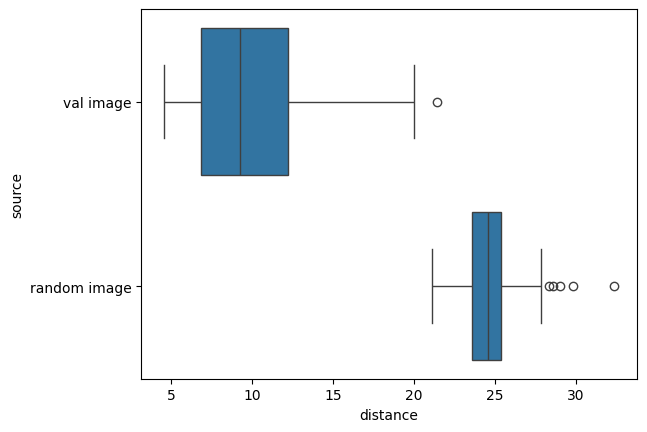

In [7]:
import seaborn as sns

df = pd.DataFrame(
    {'distance': np.r_[dists1, dists2],
     'source': ['val image']*len(dists1)+['random image']*len(dists2)})
# Just switch x and y
sns.boxplot(y=df["source"], x=df["distance"])